<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Lesson_7_1_MNIST_CONV_RES_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 7: Resnets from scratch; U-net;  & GAN

https://course.fast.ai/videos/?lesson=7

https://github.com/hiromis/notes/blob/master/Lesson7.md



In the final lesson of Practical Deep Learning for Coders we'll study one of the most important techniques in modern architectures: the skip connection. This is most famously used in the resnet, which is the architecture we've used throughout this course for image classification, and appears in many cutting edge results. We'll also look at the U-net architecture, which uses a different type of skip connection to greatly improve segmentation results (and also for similar tasks where the output structure is similar to the input).

We'll then use the U-net architecture to train a super-resolution model. This is a model which can increase the resolution of a low-quality image. Our model won't only increase resolution—it will also remove jpeg artifacts, and remove unwanted text watermarks.

In order to make our model produce high quality results, we will need to create a custom loss function which incorporates feature loss (also known as perceptual loss), along with gram loss. These techniques can be used for many other types of image generation task, such as image colorization.

Finally, we'll learn about a recent loss function known as generative adversarial loss (used in generative adversarial networks, or GANs), which can improve the quality of generative models in some contexts, at the cost of speed.

The techniques we show in this lesson include some unpublished research that:

* Let us train GANs more quickly and reliably than standard approaches, by leveraging transfer learning
* Combines architectural innovations and loss function approaches that haven't been used in this way before.

The results are stunning, and train in just a couple of hours (compared to previous approaches that take a couple of days).

# Notes


## Install 

In [0]:
!pip install imgaug==0.2.7

!pip install folium==0.2.1

!pip install --upgrade pandas

!pip install --upgrade numpy

!pip install isoweek

#!pip install --upgrade fastai

!curl -s https://course.fast.ai/setup/colab | bash

## Constants & global flags

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Import Fast.ai & PyTorch


In [3]:
import fastai
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import error_rate
import matplotlib.pyplot as plt

print("FastAI Version: " + str(fastai.__version__))

FastAI Version: 1.0.51


In [4]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## CUDA GPU *acceleration*

In [0]:
def check_cuda():
  torch.cuda.current_device()
  print("Cuda available: " + str(torch.cuda.is_available()))
  print("Cuda enabled:" + str(torch.backends.cudnn.enabled))
  #https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
  # setting device on GPU if available, else CPU
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  print()
  #Additional Info when using cuda
  if device.type == 'cuda':
    check_cuda_mem()


In [0]:
def check_cuda_mem():
      print("GPU used: " + torch.cuda.get_device_name(0))
      print('Memory Usage:')
      print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
      print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
  

In [0]:
def clear_cuda_cache(learn):
  # Clear Cuda cache, if running OOM
    learn.destroy()
    torch.cuda.empty_cache()
    check_cuda_mem()

In [11]:
check_cuda()

Cuda available: True
Cuda enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Data 

In [12]:
path = untar_data(URLs.MNIST)

path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [14]:
il = ImageList.from_folder(path, convert_mode='L')

il.items[0]


PosixPath('/root/.fastai/data/mnist_png/testing/1/6110.png')

In [0]:
defaults.cmap='binary'


In [16]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png

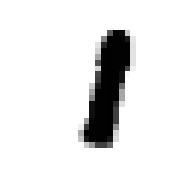

In [17]:
il[0].show()

In [19]:
sd = il.split_by_folder(train='training', valid='testing')
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [20]:
(path/'training').ls()


[PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/3'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/0')]

In [0]:
ll = sd.label_from_folder()


In [30]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,1,1,1,1
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,1,1,1,1
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0]

1 torch.Size([1, 28, 28])


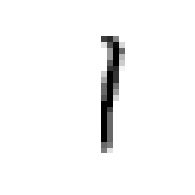

In [32]:
x.show()
print(y,x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])


In [0]:
ll = ll.transform(tfms)


In [0]:
# increase batvhsize 
bs = 128


In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]


1


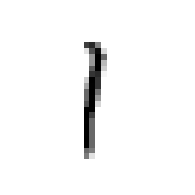

In [38]:
x.show()
print(y)

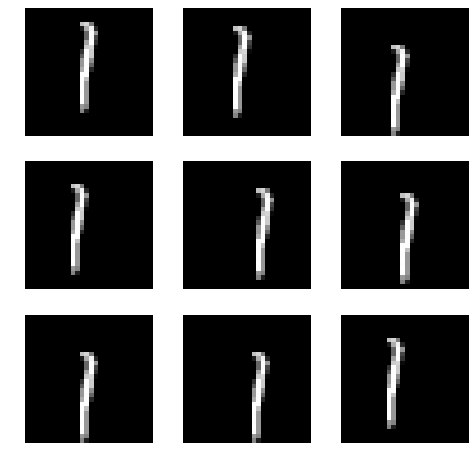

In [39]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [40]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

# Model 

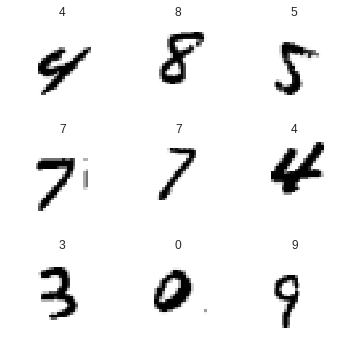

In [41]:
data.show_batch(rows=3,figsize=(5,5))

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)


In [0]:
model = nn.Sequential(
    conv(1,8),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8,16),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,32),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32,16),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,10),
    nn.BatchNorm2d(10),
    Flatten() # remove (1,1) grid
)

In [44]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
print(learn.summary())


Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [45]:
xb = xb.cuda()
model(xb).shape


torch.Size([128, 10])

# Training 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


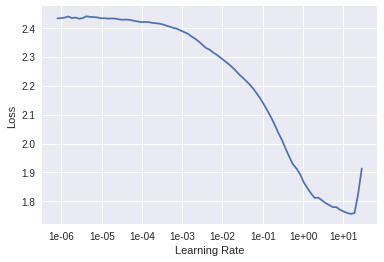

In [47]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(3, max_lr=0.1)


epoch,train_loss,valid_loss,accuracy,time
0,0.220980,0.121435,0.962800,00:36
1,0.138570,0.226311,0.926200,00:36
2,0.077711,0.038984,0.987300,00:36


# Refactor Model

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)


In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)


In [52]:
learn.fit_one_cycle(10, max_lr=0.1)


epoch,train_loss,valid_loss,accuracy,time
0,0.236223,0.225804,0.928100,00:35
1,0.186016,0.283834,0.918600,00:35
2,0.155052,0.132337,0.959800,00:35
3,0.133606,0.134520,0.957800,00:35
4,0.114545,0.086246,0.971500,00:36
5,0.100395,0.066925,0.979800,00:35
6,0.079506,0.049977,0.982700,00:36
7,0.066453,0.037286,0.988800,00:36
8,0.054756,0.027275,0.991000,00:36
9,0.050603,0.025778,0.991000,00:36


# Refactor 2: Resnet-ish¶


In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [53]:
help(res_block)


Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))


In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


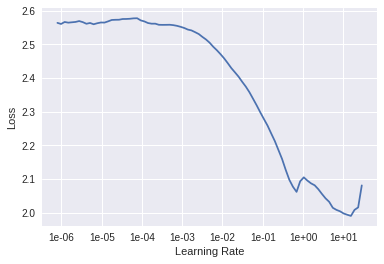

In [61]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, max_lr=0.05)


epoch,train_loss,valid_loss,accuracy,time
0,0.223831,0.208225,0.936000,00:40


In [0]:
print(learn.summary())
